# UFO 50: Camouflage SSL Segmentation

In [1]:
import os
import pickle
import json
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset

import torchvision.transforms.transforms as tvT
import torchvision.transforms.functional as tvF

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cmap = "tab20"

print(device)

cuda:0


## Load data

> Load two seperate datasets for semi-supervised learning. The first is the labeled data (images and their respective labels), and the second is the unlabeled data (images only).

***Prepare for dataset creation***

In [2]:
class CamoDataset(Dataset):
    def __init__(self, img_dir, label_dir=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        
        self.img_names = sorted(os.listdir(img_dir))
        if label_dir:
            self.label_names = sorted(
                [f for f in os.listdir(label_dir) if f.endswith(".png")])
            with open(os.path.join(label_dir, "mapping.json"), "r") as file:
                self.classes = json.load(file)
        else:
            self.label_names = None
            self.classes = None

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert("RGB")
        
        if self.label_dir:
            label_path = os.path.join(self.label_dir, self.label_names[idx])
            label = Image.open(label_path)
            if self.transform:
                img, label = self.transform(img, label)
            return img, label
        else:
            if self.transform:
                img = self.transform(img)
            return img

dataset_path = os.path.abspath("../data/datasets/camouflage_1/")
resize_dims = (224, 224)

***Compute image mean/std dev for normalization***

In [3]:
def compute_dataset_stats():
    dataset = CamoDataset(
        f"{dataset_path}/unlabeled", 
        transform=tvT.Compose([
            tvT.Resize(resize_dims, interpolation=tvT.InterpolationMode.NEAREST),
            tvT.ToTensor(),
        ])
    )
    loader = DataLoader(dataset, batch_size=64, num_workers=0)

    mean = 0.0
    std = 0.0
    total_images = 0

    for images in loader:
        images.to(device)
        total_images += images.size(0)
        mean += images.mean(dim=[0, 2, 3]) * images.size(0)
        std += images.std(dim=[0, 2, 3]) * images.size(0)

    mean /= total_images
    std /= total_images
    
    return mean, std

pickle_path = "dataset_stats.pkl"

if os.path.exists(pickle_path):
    with open(pickle_path, "rb") as f:
        mean, std = pickle.load(f)
else:
    mean, std = compute_dataset_stats()
    with open(pickle_path, "wb") as f:
        pickle.dump((mean, std), f)
        
print(mean)
print(std)

tensor([0.3169, 0.3255, 0.2559])
tensor([0.2708, 0.2615, 0.2289])


***Load datasets***

In [4]:
# Define transforms
def transform(img, label=None):
    # Resize
    img = tvF.resize(img, resize_dims)
    if label is not None:
        label = tvF.resize(label, resize_dims, interpolation=Image.NEAREST)
    
    # To Tensor
    img = tvF.to_tensor(img)
    if label is not None:
        label = tvF.to_tensor(label)
    
    # Normalize
    img = tvF.normalize(img, mean=mean, std=std)
    
    if label is not None:
        return img, label.long()
    else:
        return img

labeled_dataset = CamoDataset(f"{dataset_path}/labeled", f"{dataset_path}/labels", transform=transform)
unlabeled_dataset = CamoDataset(f"{dataset_path}/unlabeled", transform=transform)

***Show original image, transformed image, and labels***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.244643..2.4968894].


Text(0.5, 1.0, 'Ground Truth Labels')

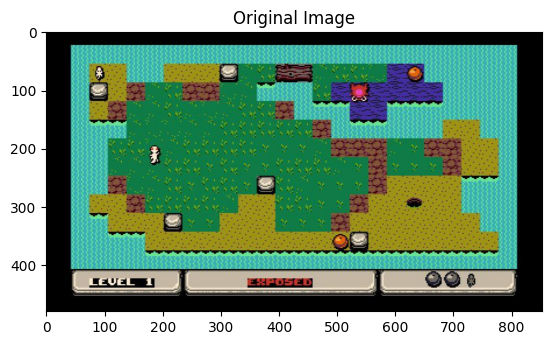

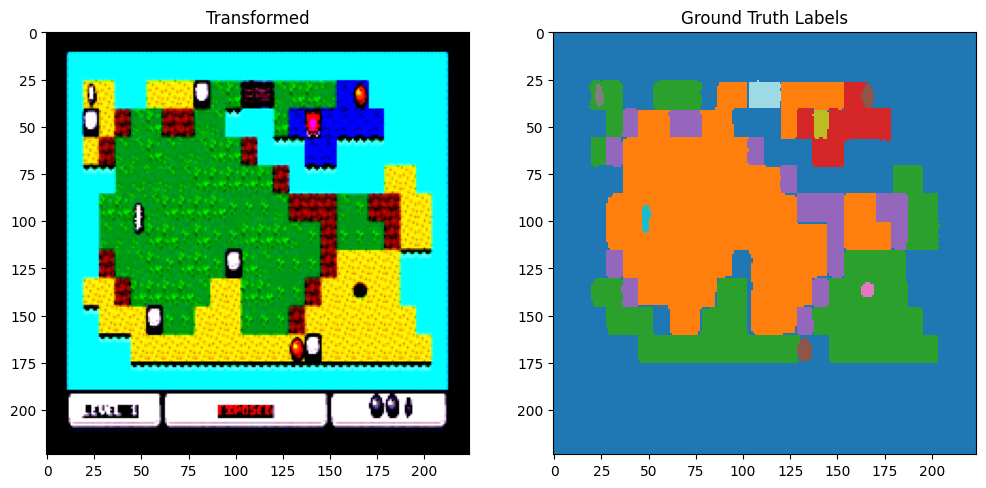

In [5]:
img_idx = 0

img, labels = labeled_dataset[img_idx]
img_name = labeled_dataset.img_names[img_idx]

raw_img_path = os.path.join(dataset_path, "labeled", img_name)
raw_img = Image.open(raw_img_path).convert("RGB")

# Switch axes for viz
img = img.permute(1, 2, 0)
labels = labels.permute(1, 2, 0)

# Visualization
plt.imshow(raw_img)
plt.title("Original Image")
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
axes[0].imshow(img)
axes[0].set_title("Transformed")
axes[1].imshow(labels, interpolation="none", cmap=cmap)
axes[1].set_title("Ground Truth Labels")

## Contrastive pretraining

> Contrastive learning is a self-supervised machine learning technique where samples are encoded in an embedding space in which similar samples are closer than dissimilar samples.
>
> The goal is to transform the data in a way that makes performing tasks such as classification easier for the final model. Better yet, this can be accomplished by using plentiful unlabeled data.
>
> A encoder for contrastive pretraining is created below.

***Prepare for dataset creation***

In [6]:
# Data agumentation
# norm_params = [0.5 for _ in range(3)]
contrastive_transforms = tvT.Compose([
    tvT.RandomResizedCrop(resize_dims, scale=(0.4, 1.0)),        # Crop
    tvT.RandomHorizontalFlip(),                                    # Flip
    tvT.RandomVerticalFlip(),                                      # Flip
    tvT.RandomApply([tvT.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.5), # HSV stuff
    tvT.RandomGrayscale(p=0.5),                                    # Grayscale (learn shapes)
    tvT.ToTensor(),
    tvT.Normalize(mean=mean, std=std)
])

class ContrastiveCamoDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img1 = self.transform(img)
            img2 = self.transform(img)
        return img1, img2

***Define contrastive encoder***

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class ContrastiveModel(nn.Module):
    """
    Model for contrastive pretraining. The encoder can be used in a segmentation
    autoencoder, but the projection head is needed for contrastive learning.

    Currently uses resnet18 and expects 224x224 images as input.
    """
    def __init__(self, projection_dim=128, enc_dims=7):
        super(ContrastiveModel, self).__init__()
        self.encoder = resnet18(weights=None)
        num_features = self.encoder.fc.in_features

        # Projection head (encoder output -> embedding for contrastive learning)
        self.projection = nn.Sequential(
            nn.Linear(num_features * enc_dims * enc_dims, num_features),
            nn.ReLU(),
            nn.Linear(num_features, projection_dim)
        )

    def forward(self, x):
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)

        x = self.encoder.layer1(x)
        x = self.encoder.layer2(x)
        x = self.encoder.layer3(x)
        x = self.encoder.layer4(x)

        # Save flattened output as vector for contrastive learning
        flat = torch.flatten(x, start_dim=1)
        embedded = self.projection(flat)

        return x, embedded
    
def nt_xent_loss(emb_i, emb_j, temperature=0.1):
    batch_size = emb_i.shape[0]
    z = torch.cat([emb_i, emb_j], dim=0)  # (2N, D)
    z = F.normalize(z, dim=1)  # Normalize embeddings

    # Compute similarity matrix
    similarity_matrix = torch.matmul(z, z.T)  # (2N, 2N)
    similarity_matrix = similarity_matrix / temperature

    # Create labels
    labels = torch.arange(batch_size).to(emb_i.device)
    labels = torch.cat([labels + batch_size, labels], dim=0)  # Positive indices

    # Mask self-similarities
    mask = torch.eye(2 * batch_size, dtype=torch.bool).to(emb_i.device)
    similarity_matrix = similarity_matrix.masked_fill(mask, float('-inf'))

    # Compute cross-entropy loss
    loss = F.cross_entropy(similarity_matrix, labels)
    return loss

***Create dataset and loader***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0946966..2.3090854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.244643..1.5956404].


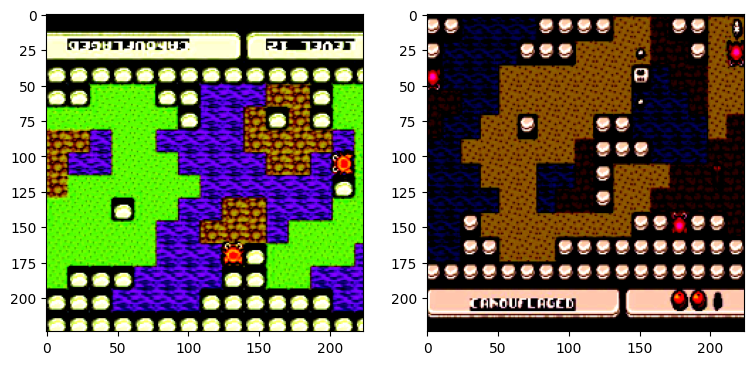

In [8]:
contrastive_dataset = ContrastiveCamoDataset(
    f"{dataset_path}/unlabeled", transform=contrastive_transforms)

# num_samples = 2_000
# indices = random.sample(range(len(contrastive_dataset)), num_samples)
# reduced_dataset = Subset(contrastive_dataset, indices)

# print("Pulling data to memory and transforming...")
# contrastive_dataset_mem = InMemoryDataset(contrastive_dataset)
# print("Pull complete.")

contrastive_batch_size = 128  # Higher == more negative samples == better
contrastive_loader = DataLoader(
    contrastive_dataset,
    batch_size=contrastive_batch_size, shuffle=True, drop_last=True,
    num_workers=0, pin_memory=True
)

img_idx = 3
img1, img2 = next(iter(contrastive_loader))
img1 = img1[img_idx]
img2 = img2[img_idx]
fig, axes = plt.subplots(1, 2, figsize=(9, 5))
axes[0].imshow(img1.permute(1, 2, 0).cpu().numpy())
axes[1].imshow(img2.permute(1, 2, 0).cpu().numpy())
plt.show()

***Pretrain encoder***

In [9]:
def train_contrastive(model, loader, optimizer, epochs):
    model.train()
    grad_scaler = torch.amp.GradScaler()
    
    prev_avg_loss = float("inf")

    for epoch in range(epochs):
        total_loss = 0

        for img1, img2 in loader:
            img1 = img1.to(device, non_blocking=True)
            img2 = img2.to(device, non_blocking=True)
            optimizer.zero_grad()

            with torch.autocast(device_type="cuda"):
                _, z_i = model(img1)
                _, z_j = model(img2)
                loss = nt_xent_loss(z_i, z_j)

            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()
            
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

        if avg_loss >= prev_avg_loss:
            break

        prev_avg_loss = avg_loss

contrastive_model = ContrastiveModel().to(device)
optimizer = torch.optim.Adam(contrastive_model.parameters(), lr=1e-3)

weights_path = "contrastive_model_weights.pth"
epochs = 10

if os.path.exists(weights_path):
    contrastive_model.load_state_dict(torch.load(weights_path, weights_only=True))
    contrastive_model.eval()  # Set the model to evaluation mode
    print(f"Weights loaded successfully from '{weights_path}'.")
else:
    train_contrastive(contrastive_model, contrastive_loader, optimizer, epochs=epochs)
    torch.save(contrastive_model.state_dict(), weights_path)

Weights loaded successfully from 'contrastive_model_weights.pth'.


## Train segmentation model

***Prepare data loaders***

In [23]:
batch_size = 16
train_percent = 0.8

train_size = int(train_percent * len(labeled_dataset))
test_size = len(labeled_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(labeled_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [18]:
from sklearn.model_selection import train_test_split

def get_class_presence(dataset, num_classes):
    # Create a binary matrix where each row corresponds to an image
    # and columns indicate the presence of a class
    class_presence = np.zeros((len(dataset), num_classes), dtype=int)
    for idx, (_, label) in enumerate(dataset):
        label_np = np.array(label)
        unique_classes = np.unique(label_np)
        class_presence[idx, unique_classes] = 1
    return class_presence

batch_size = 16
train_percent = 0.8

# Compute per-image class presence
num_classes = len(labeled_dataset.classes)  # Load from mapping.json
class_presence = get_class_presence(labeled_dataset, num_classes)

# Convert to a per-class label for stratification
# Sum over rows to count the number of images containing each class
per_class_labels = class_presence.sum(axis=1)

# Stratified split based on per-class counts
train_indices, test_indices = train_test_split(
    range(len(labeled_dataset)),
    test_size=(1 - train_percent),
    stratify=per_class_labels
)

# Create subsets
train_dataset = torch.utils.data.Subset(labeled_dataset, train_indices)
test_dataset = torch.utils.data.Subset(labeled_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


C:\Users\eric\AppData\Local\Temp\ipykernel_2072\3575832545.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  label_np = np.array(label)


***Define model***

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class SegmentationModel(nn.Module):
    """
    Image segmentation autoencoder that uses a pretrained contrastive learning
    model as an encoder and skip connections.
    """
    def __init__(self, n_classes, encoder):
        super(SegmentationModel, self).__init__()

        self.encoder = encoder  # Pretrained encoder

        # Decoder layers
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up1 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)

        # Final output layer
        self.final_layer = nn.Conv2d(64, n_classes, kernel_size=1)

        self.residual_proj = nn.Conv2d(3, n_classes, kernel_size=1)

    def forward(self, x):
        img = x

        # Encoder ======
        x1 = self.encoder.conv1(x)
        x1 = self.encoder.bn1(x1)
        x1 = self.encoder.relu(x1)

        x2 = self.encoder.layer1(self.encoder.maxpool(x1))
        x3 = self.encoder.layer2(x2)
        x4 = self.encoder.layer3(x3)
        x5 = self.encoder.layer4(x4)

        # Decoder ======
        x = self.up4(x5) + x4
        x = self.up3(x) + x3
        x = self.up2(x) + x2
        x = self.up1(x) + x1

        # Final upsampling to match original resolution
        x = F.interpolate(x, size=(224, 224), mode="bilinear", align_corners=False)

        out = self.final_layer(x)

        # Residual connection
        residual = self.residual_proj(
            F.interpolate(img, size=out.shape[-2:], mode="bilinear", align_corners=False)
        )
        out = out + residual

        return out

***Train model***

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # One-hot encode the target
        targets_one_hot = F.one_hot(targets, num_classes=logits.shape[1]).permute(0, 3, 1, 2).float()

        # Compute Dice Coefficient
        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)

        # Dice Loss is 1 - Dice Coefficient
        return 1.0 - dice.mean()
    
class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_cce=0.5):
        super(CombinedLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.cce_loss = nn.CrossEntropyLoss()
        self.weight_dice = weight_dice
        self.weight_cce = weight_cce

    def forward(self, logits, targets):
        dice_loss = self.dice_loss(logits, targets)
        cce_loss = self.cce_loss(logits, targets)
        return self.weight_dice * dice_loss + self.weight_cce * cce_loss

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()
    
class TverskyLoss(nn.Module):
    def __init__(self, n_classes, alpha=0.1, beta=0.9, eps=1e-6):
        """
        Tversky loss for imbalanced classes, by default punishes mislabelling
        rare classes w/ high beta

        Args:
            alpha (float): Weight for false positives.
            beta (float): Weight for false negatives.
            eps (float): Smoothing factor to avoid division by zero.
        """
        super(TverskyLoss, self).__init__()
        self.n_classes = n_classes
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    def forward(self, logits, targets):
        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=self.n_classes).permute(0, 3, 1, 2)
        
        # Apply softmax to logits
        probs = torch.softmax(logits, dim=1)
        
        # Compute true positives, false positives, and false negatives
        tp = (probs * targets_one_hot).sum(dim=(2, 3))
        fp = ((1 - targets_one_hot) * probs).sum(dim=(2, 3))
        fn = (targets_one_hot * (1 - probs)).sum(dim=(2, 3))
        
        # Compute Tversky index
        tversky_index = (tp + self.eps) / (tp + self.alpha * fp + self.beta * fn + self.eps)
        
        # Compute Tversky loss
        tversky_loss = 1 - tversky_index.mean()
        return tversky_loss

In [21]:
n_classes = len(labeled_dataset.classes)

segmentation_model = SegmentationModel(n_classes=n_classes, encoder=contrastive_model.encoder)
segmentation_model.to(device)

criterion = TverskyLoss(n_classes)
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4)

def train_segmentation(model, loader, optimizer, criterion, epochs, print_freq=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0

        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(imgs)
            outputs = F.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            
            loss = criterion(outputs, labels.squeeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)

        if (epoch + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

weights_path = "segmentation_model_weights.pth"
epochs = 200
overwrite = True
if os.path.exists(weights_path) and not overwrite:
    segmentation_model.load_state_dict(torch.load(weights_path, weights_only=True))
    segmentation_model.eval()  # Set the model to evaluation mode
    print(f"Weights loaded successfully from '{weights_path}'.")
else:
    train_segmentation(segmentation_model, train_loader, optimizer, criterion, epochs=epochs)
    torch.save(segmentation_model.state_dict(), weights_path)

Epoch [10/200], Loss: 0.8638
Epoch [20/200], Loss: 0.7428
Epoch [30/200], Loss: 0.6830
Epoch [40/200], Loss: 0.6165
Epoch [50/200], Loss: 0.5814
Epoch [60/200], Loss: 0.5476
Epoch [70/200], Loss: 0.5208
Epoch [80/200], Loss: 0.5125
Epoch [90/200], Loss: 0.4904
Epoch [100/200], Loss: 0.4770
Epoch [110/200], Loss: 0.4563
Epoch [120/200], Loss: 0.4201
Epoch [130/200], Loss: 0.3222
Epoch [140/200], Loss: 0.2320
Epoch [150/200], Loss: 0.1966
Epoch [160/200], Loss: 0.1786
Epoch [170/200], Loss: 0.1660
Epoch [180/200], Loss: 0.1488
Epoch [190/200], Loss: 0.1453
Epoch [200/200], Loss: 0.1441


***Test model***

In [23]:
def evaluate_segmentation(model, loader, n_classes):
    model.eval()
    correct_pixels = 0
    total_pixels = 0
    iou_per_class = torch.zeros(n_classes, device=device)
    dice_per_class = torch.zeros(n_classes, device=device)
    eps = 1e-6  # To avoid division by zero

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            # outputs = F.interpolate(outputs, size=labels.shape[-2:], mode="bilinear", align_corners=False)
            preds = torch.argmax(outputs, dim=1)  # Get predicted classes

            # Pixel accuracy
            correct_pixels += (preds == labels.squeeze(1)).sum().item()
            total_pixels += labels.numel()

            # IoU and Dice Coefficient
            for cls in range(n_classes):
                pred_mask = (preds == cls)
                true_mask = (labels.squeeze(1) == cls)

                intersection = (pred_mask & true_mask).sum().float()
                union = (pred_mask | true_mask).sum().float()
                dice = 2 * intersection / (pred_mask.sum().float() + true_mask.sum().float() + eps)

                if union > 0:
                    iou_per_class[cls] += intersection / (union + eps)
                dice_per_class[cls] += dice

    # Aggregate metrics
    pixel_accuracy = correct_pixels / total_pixels
    iou_per_class = iou_per_class / len(loader)
    dice_per_class = dice_per_class / len(loader)

    print(labeled_dataset.classes.keys())
    print(f"Pixel Accuracy: {pixel_accuracy:.4f}")
    print(f"IoU per class: {iou_per_class.tolist()}")
    print(f"Dice per class: {dice_per_class.tolist()}")

    return pixel_accuracy, iou_per_class.cpu().numpy(), dice_per_class.cpu().numpy()

evaluate_segmentation(segmentation_model, test_loader, len(labeled_dataset.classes))

dict_keys(['__ignore__', '_background_', 'Grass', 'Sand', 'Marsh', 'Stone', 'Orange', 'Exit', 'Baby', 'Enemy', 'Player', 'Log', 'RainStone', 'SunStone', 'Button', 'Stairs'])
Pixel Accuracy: 0.9600
IoU per class: [0.9422798156738281, 0.9103928804397583, 0.9118968844413757, 0.9216231107711792, 0.8920408487319946, 0.6034972071647644, 0.45029911398887634, 0.1334196925163269, 0.7809914350509644, 0.2841474413871765, 0.8073973059654236, 0.8585913181304932, 0.7866568565368652, 0.6057391166687012, 0.0, 0.0]
Dice per class: [0.9702770709991455, 0.9530872106552124, 0.9538129568099976, 0.9592074155807495, 0.9428187608718872, 0.7295660376548767, 0.6114658713340759, 0.21063394844532013, 0.8769434690475464, 0.44241970777511597, 0.8900288343429565, 0.9234247207641602, 0.8804398775100708, 0.7489223480224609, 0.0, 0.0]


(0.9599709024234694,
 array([0.9422798 , 0.9103929 , 0.9118969 , 0.9216231 , 0.89204085,
        0.6034972 , 0.4502991 , 0.13341969, 0.78099144, 0.28414744,
        0.8073973 , 0.8585913 , 0.78665686, 0.6057391 , 0.        ,
        0.        ], dtype=float32),
 array([0.9702771 , 0.9530872 , 0.95381296, 0.9592074 , 0.94281876,
        0.72956604, 0.6114659 , 0.21063395, 0.87694347, 0.4424197 ,
        0.89002883, 0.9234247 , 0.8804399 , 0.74892235, 0.        ,
        0.        ], dtype=float32))

In [19]:
x = set()

for _, labels in train_dataset:
    for l in labels.unique():
        x.add(l.item())

x

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}

## Fine-tuning with pseudolabel generation

***Prepare***

In [ ]:
class PseudoLabeledDataset(Dataset):
    def __init__(self, unlabeled_dataset, pseudo_labels):
        self.unlabeled_dataset = unlabeled_dataset
        self.pseudo_labels = pseudo_labels

    def __len__(self):
        return len(self.unlabeled_dataset)

    def __getitem__(self, idx):
        img = self.unlabeled_dataset[idx]

        label = self.pseudo_labels[idx]
        label = label.squeeze(0)

        return img, label
    
def generate_pseudo_labels(model, unlabeled_loader, confidence_threshold=0.8):
    model.eval()
    pseudo_labels = []
    with torch.no_grad():
        for imgs in unlabeled_loader:
            imgs = imgs.to(device)

            outputs = model(imgs)  # Logits output
            probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
            predictions = torch.argmax(probabilities, dim=1)  # Predicted class indices

            high_confidence_mask = torch.max(probabilities, dim=1)[0] > confidence_threshold
            predictions[~high_confidence_mask] = 0  # Ignore low-confidence predictions

            predictions = predictions.unsqueeze(0)
            pseudo_labels.append(predictions.cpu())  # Store pseudo-labels

    return torch.cat(pseudo_labels, dim=0)  # Combine all pseudo-labels

***Fine-tune with pseudolabels***

In [ ]:
optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=1e-4)
criterion = TverskyLoss(n_classes)

iters = 1
epochs = 5
for _ in range(iters):
    # Generate pseudo-labels
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16, shuffle=False)

    print("Generating labels...")
    pseudo_labels = generate_pseudo_labels(segmentation_model, unlabeled_loader)

    # Create pseudo-labeled dataset
    pseudo_labeled_dataset = PseudoLabeledDataset(unlabeled_dataset, pseudo_labels)

    # Combine labeled and pseudo-labeled datasets
    combined_dataset = ConcatDataset([labeled_dataset, pseudo_labeled_dataset])

    # Create a new loader for combined dataset
    combined_loader = DataLoader(combined_dataset, batch_size=16, shuffle=True)

    # Train with the combined loader
    # train_segmentation(segmentation_model, combined_loader, optimizer, criterion, epochs=epochs)

Generating labels...


RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 16 but got size 12 for tensor number 398 in the list.

In [ ]:
# for idx in range(30):
idx = 88
real, pseudo = labeled_dataset[idx][1], pseudo_labeled_dataset[idx][1]
print(real.shape, torch.unique(real))
print(pseudo.shape, torch.unique(pseudo))
print("====")

real

torch.Size([1, 224, 224]) tensor([ 0,  1,  2,  3,  4,  5,  6,  8, 10, 11, 12, 13])
torch.Size([224, 224]) tensor([0, 1, 3])
====


tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])

In [ ]:
# Train with the combined loader
train_segmentation(segmentation_model, combined_loader, optimizer, criterion, epochs=20)

RuntimeError: stack expects each tensor to be equal size, but got [224, 224] at entry 0 and [1, 224, 224] at entry 5

In [ ]:
i = 0
max_iter = 10
for img, labels in combined_loader:
    print(torch.min(labels), torch.max(labels))
    i += 1
    if i > max_iter:
        break

tensor(-2) tensor(1)
tensor(-2) tensor(1)
tensor(-2) tensor(1)
tensor(-2) tensor(1)
tensor(-2) tensor(10)
tensor(-2) tensor(1)
tensor(-2) tensor(1)
tensor(-2) tensor(1)
tensor(-2) tensor(14)
tensor(-2) tensor(1)
tensor(-2) tensor(1)


***Evaluate***

In [ ]:
evaluate_segmentation(segmentation_model, test_loader, len(labeled_dataset.classes))